# Kahve Tüketimi ve Stres İlişkisi Analizi

Bu notebook, anket verileri üzerinde veri madenciliği ve makine öğrenmesi yöntemlerini uygulayarak kahve tüketimi ile stres düzeyi arasındaki ilişkiyi incelemektedir.


In [99]:
# Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# Veri Yükleme
df = pd.read_csv('anket.csv')
print(f"Veri yüklendi: {df.shape[0]} katılımcı, {df.shape[1]} sütun")

# Gereksiz sütunları çıkar
df_clean = df.drop(['Zaman damgası', 'Kahve içme nedeni? '], axis=1)
df_clean.columns = ['Yas', 'Cinsiyet', 'Is_Yogunlugu', 'Kahve_Miktar', 
                    'Kahve_Zamani', 'Kahve_Hissi', 'Stres_Duzeyi', 
                    'Uyku_Suresi', 'Ruh_Hali', 'Stresli_Kahve']

# Çoklu yanıtları sadeleştir
def simplify(value):
    if pd.isna(value): return value
    return str(value).split(',')[0].strip() if ',' in str(value) else str(value)

df_ml = df_clean.copy()
for col in ['Kahve_Zamani', 'Kahve_Hissi', 'Uyku_Suresi', 'Ruh_Hali']:
    df_ml[col] = df_ml[col].apply(simplify)

print("Veri ön işleme tamamlandı.")


Veri yüklendi: 257 katılımcı, 12 sütun
Veri ön işleme tamamlandı.


## Veri Seti Dağılımları


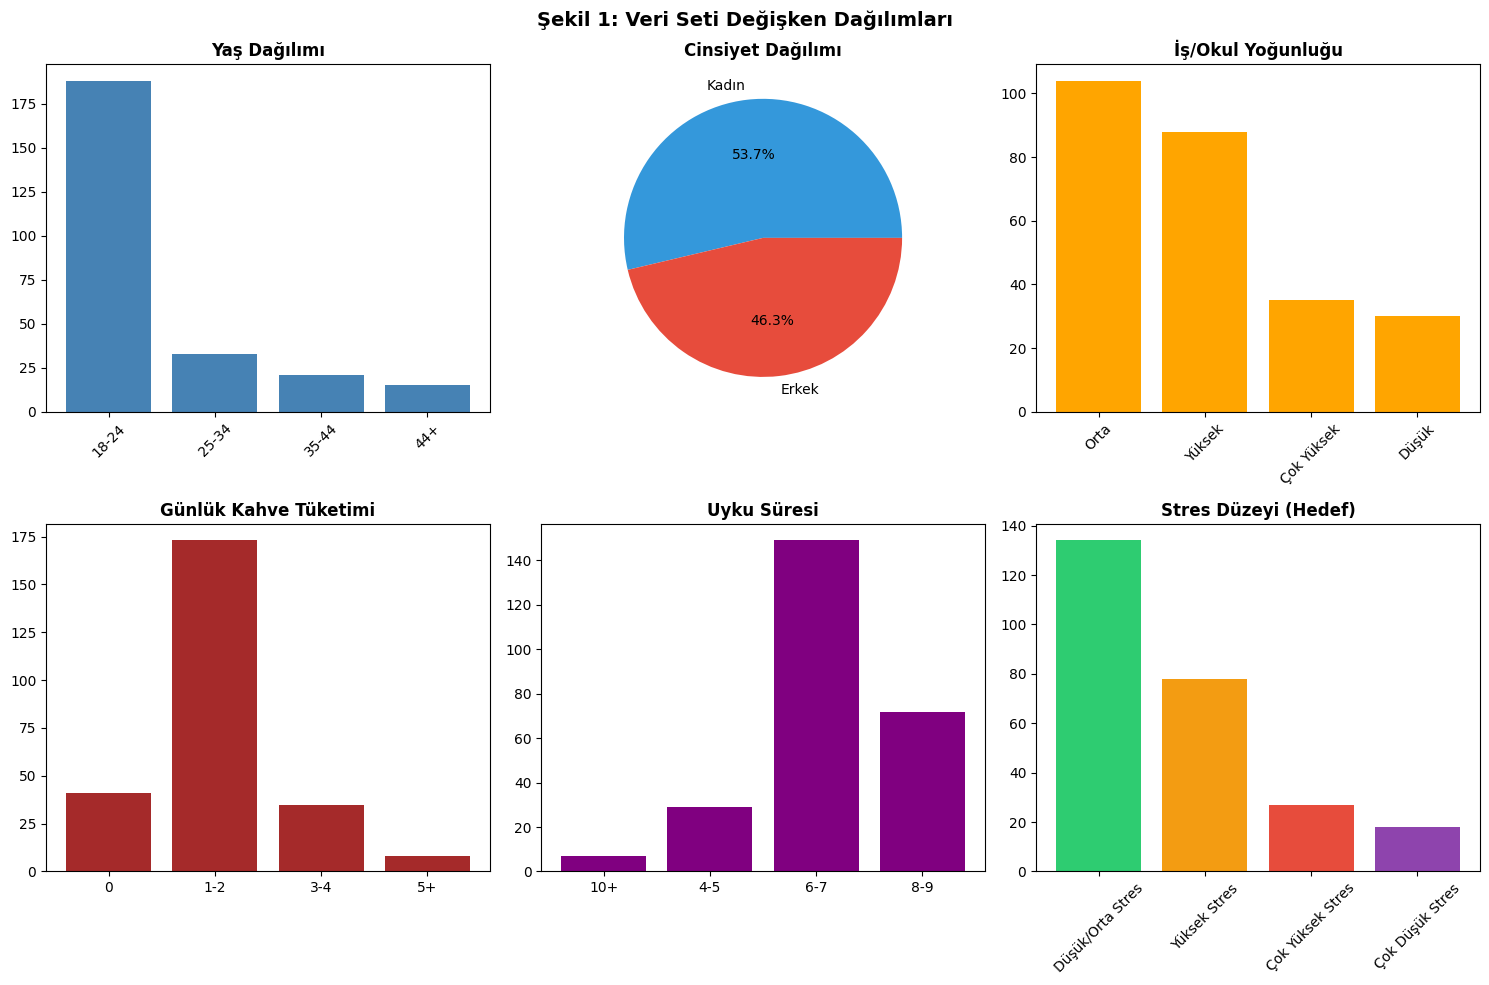

✅ Görsel kaydedildi: sekil1_veri_dagilimi.png


In [100]:
# Veri Dağılımı Görselleri
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Yaş Dağılımı
yas = df_clean['Yas'].value_counts().sort_index()
axes[0,0].bar(yas.index, yas.values, color='steelblue')
axes[0,0].set_title('Yaş Dağılımı', fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Cinsiyet Dağılımı
cinsiyet = df_clean['Cinsiyet'].value_counts()
axes[0,1].pie(cinsiyet.values, labels=cinsiyet.index, autopct='%1.1f%%', colors=['#3498db','#e74c3c','#2ecc71'])
axes[0,1].set_title('Cinsiyet Dağılımı', fontweight='bold')

# 3. İş Yoğunluğu
is_yog = df_clean['Is_Yogunlugu'].value_counts()
axes[0,2].bar(is_yog.index, is_yog.values, color='orange')
axes[0,2].set_title('İş/Okul Yoğunluğu', fontweight='bold')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Kahve Miktarı
kahve = df_clean['Kahve_Miktar'].value_counts().sort_index()
axes[1,0].bar(kahve.index, kahve.values, color='brown')
axes[1,0].set_title('Günlük Kahve Tüketimi', fontweight='bold')

# 5. Uyku Süresi
uyku = df_ml['Uyku_Suresi'].value_counts().sort_index()
axes[1,1].bar(uyku.index, uyku.values, color='purple')
axes[1,1].set_title('Uyku Süresi', fontweight='bold')

# 6. Stres Düzeyi (Hedef Değişken)
stres = df_clean['Stres_Duzeyi'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']
axes[1,2].bar(stres.index, stres.values, color=colors)
axes[1,2].set_title('Stres Düzeyi (Hedef)', fontweight='bold')
axes[1,2].tick_params(axis='x', rotation=45)

plt.suptitle('Şekil 1: Veri Seti Değişken Dağılımları', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sekil1_veri_dagilimi.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Görsel kaydedildi: sekil1_veri_dagilimi.png")


## Korelasyon Analizi


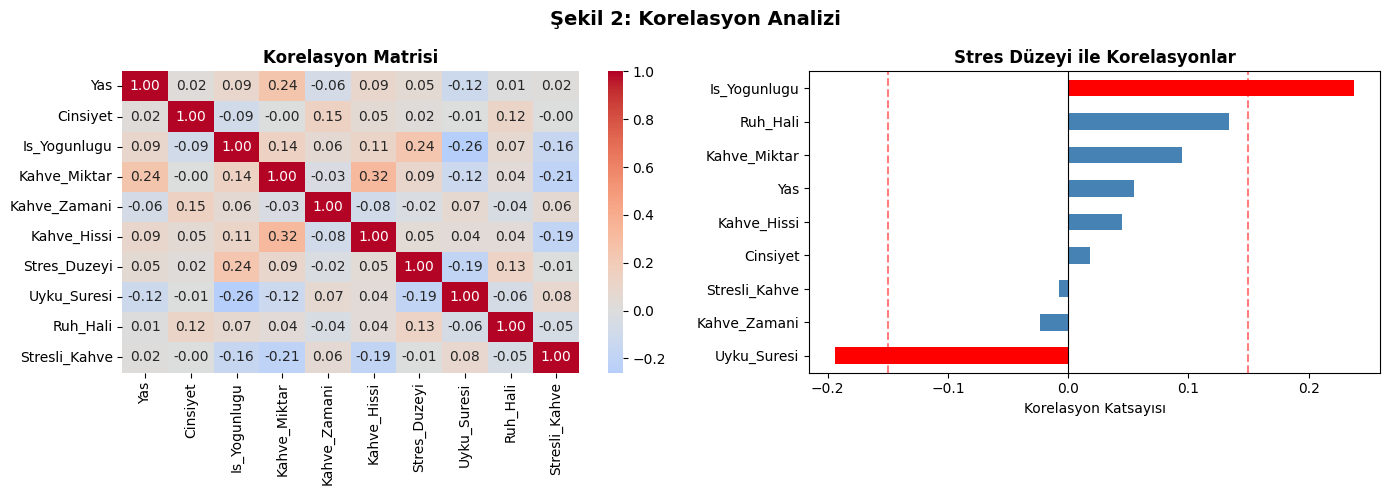


📊 Stres ile En Yüksek Korelasyonlar:
  • Is_Yogunlugu: +0.238
  • Ruh_Hali: +0.134
  • Kahve_Miktar: +0.095


In [101]:
# Label Encoding
df_encoded = df_ml.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Korelasyon Matrisi
corr_matrix = df_encoded.corr()
stres_corr = corr_matrix['Stres_Duzeyi'].drop('Stres_Duzeyi').sort_values()

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Isı Haritası
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=axes[0])
axes[0].set_title('Korelasyon Matrisi', fontweight='bold')

# Stres Korelasyonları
colors = ['red' if abs(x) >= 0.15 else 'steelblue' for x in stres_corr.values]
stres_corr.plot(kind='barh', color=colors, ax=axes[1])
axes[1].axvline(x=0, color='black', linewidth=0.8)
axes[1].axvline(x=0.15, color='red', linestyle='--', alpha=0.5)
axes[1].axvline(x=-0.15, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Stres Düzeyi ile Korelasyonlar', fontweight='bold')
axes[1].set_xlabel('Korelasyon Katsayısı')

plt.suptitle('Şekil 2: Korelasyon Analizi', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sekil2_korelasyon.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Stres ile En Yüksek Korelasyonlar:")
for feat, val in stres_corr.sort_values(ascending=False).head(3).items():
    print(f"  • {feat}: {val:+.3f}")


## Feature Importance (Random Forest)


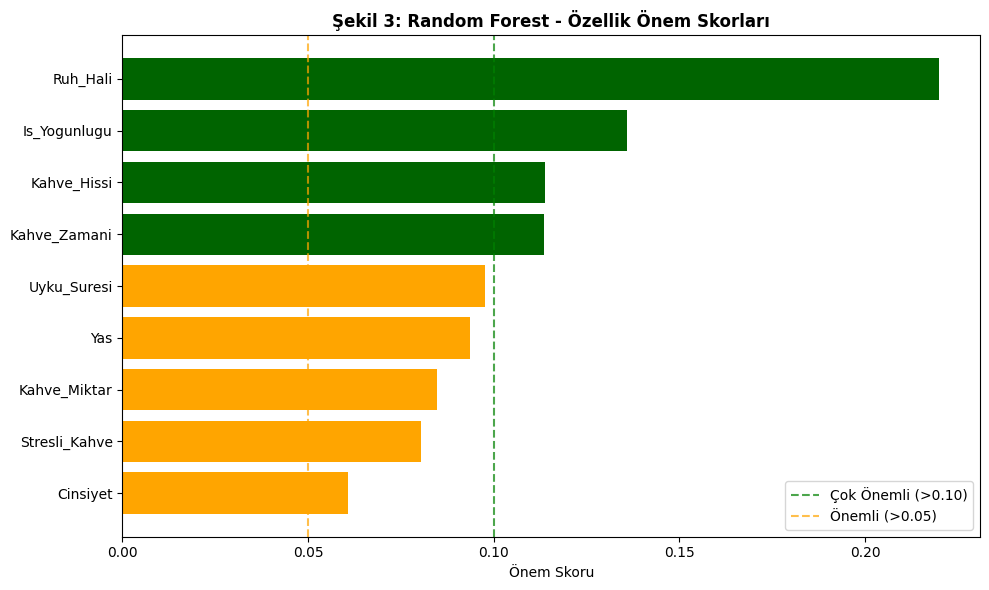


📊 En Önemli Özellikler:
  • Ruh_Hali: %22.0
  • Is_Yogunlugu: %13.6
  • Kahve_Hissi: %11.4
  • Kahve_Zamani: %11.4


In [ ]:
# Train-Test Split
X = df_encoded.drop('Stres_Duzeyi', axis=1)
y = df_encoded['Stres_Duzeyi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest ile Feature Importance
rf_imp = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_imp.fit(X_train, y_train)

# Feature Importance DataFrame
fi_df = pd.DataFrame({
    'Özellik': X.columns,
    'Önem': rf_imp.feature_importances_
}).sort_values('Önem', ascending=True)

# Görselleştirme
plt.figure(figsize=(10, 6))
colors = ['darkgreen' if x > 0.10 else 'orange' if x > 0.05 else 'gray' for x in fi_df['Önem']]
plt.barh(fi_df['Özellik'], fi_df['Önem'], color=colors)
plt.xlabel('Önem Skoru')
plt.title('Şekil 3: Random Forest - Özellik Önem Skorları', fontweight='bold', fontsize=12)
plt.axvline(x=0.10, color='green', linestyle='--', alpha=0.7, label='Çok Önemli (>0.10)')
plt.axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Önemli (>0.05)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('sekil3_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n En Önemli Özellikler:")
for _, row in fi_df.sort_values('Önem', ascending=False).head(4).iterrows():
    print(f"  • {row['Özellik']}: %{row['Önem']*100:.1f}")


## Model Eğitimi ve Sonuçlar (4 Sınıflı)


In [103]:
# 4 Farklı Model Eğitimi
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=2, random_state=42),
    'Naive Bayes': GaussianNB()
}

results = []
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1})
    predictions[name] = y_pred

# Sonuç Tablosu
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("📊 MODEL PERFORMANSLARI (4 Sınıf)")
print("="*50)
print(results_df.to_string(index=False))
print(f"\n🏆 En İyi Model: {results_df.iloc[0]['Model']} (Accuracy: {results_df.iloc[0]['Accuracy']:.4f})")


📊 MODEL PERFORMANSLARI (4 Sınıf)
        Model  Accuracy  F1-Score
Decision Tree  0.557692  0.531775
          KNN  0.519231  0.464437
  Naive Bayes  0.519231  0.504915
Random Forest  0.500000  0.453657

🏆 En İyi Model: Decision Tree (Accuracy: 0.5577)


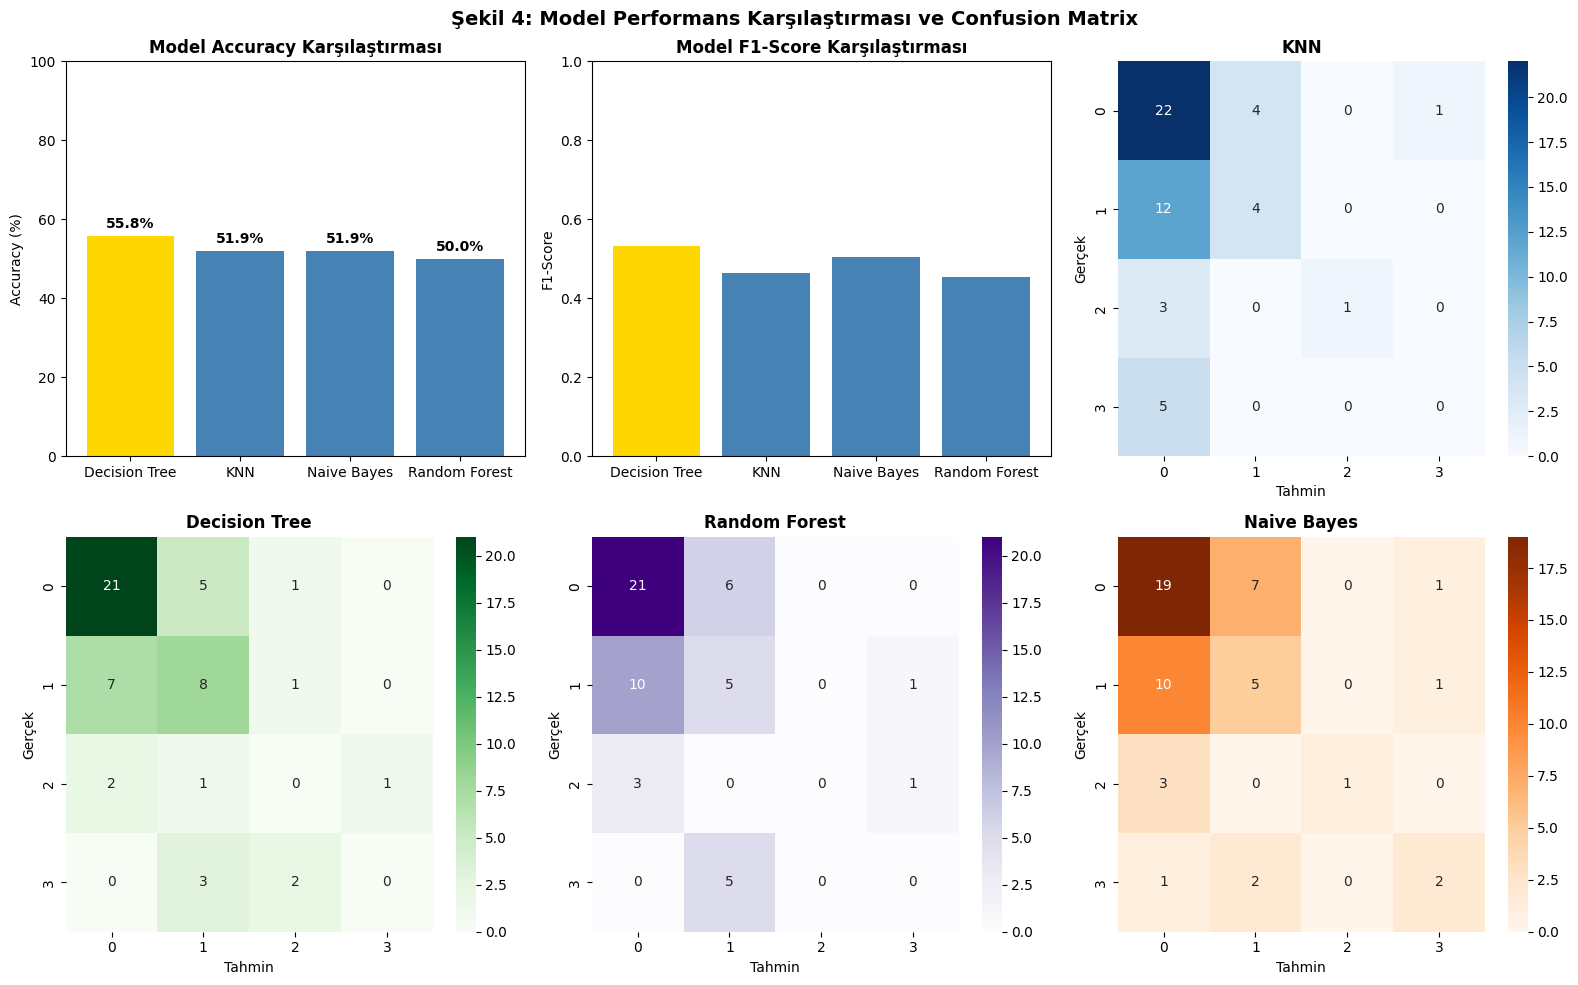

In [104]:
# Model Karşılaştırma ve Confusion Matrix
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Accuracy Karşılaştırma
model_names = results_df['Model'].values
accuracies = results_df['Accuracy'].values * 100
colors_bar = ['gold' if i == 0 else 'steelblue' for i in range(len(model_names))]
axes[0,0].bar(model_names, accuracies, color=colors_bar)
axes[0,0].set_ylabel('Accuracy (%)')
axes[0,0].set_title('Model Accuracy Karşılaştırması', fontweight='bold')
axes[0,0].set_ylim([0, 100])
for i, v in enumerate(accuracies):
    axes[0,0].text(i, v+2, f'{v:.1f}%', ha='center', fontweight='bold')

# 2. F1-Score Karşılaştırma
f1_scores = results_df['F1-Score'].values
axes[0,1].bar(model_names, f1_scores, color=colors_bar)
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_title('Model F1-Score Karşılaştırması', fontweight='bold')
axes[0,1].set_ylim([0, 1])

# 3-6. Confusion Matrices
cms = ['Blues', 'Greens', 'Purples', 'Oranges']
for idx, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[(idx+2)//3, (idx+2)%3]
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cms[idx], ax=ax)
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_ylabel('Gerçek')
    ax.set_xlabel('Tahmin')

plt.suptitle('Şekil 4: Model Performans Karşılaştırması ve Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sekil4_model_sonuclari.png', dpi=150, bbox_inches='tight')
plt.show()


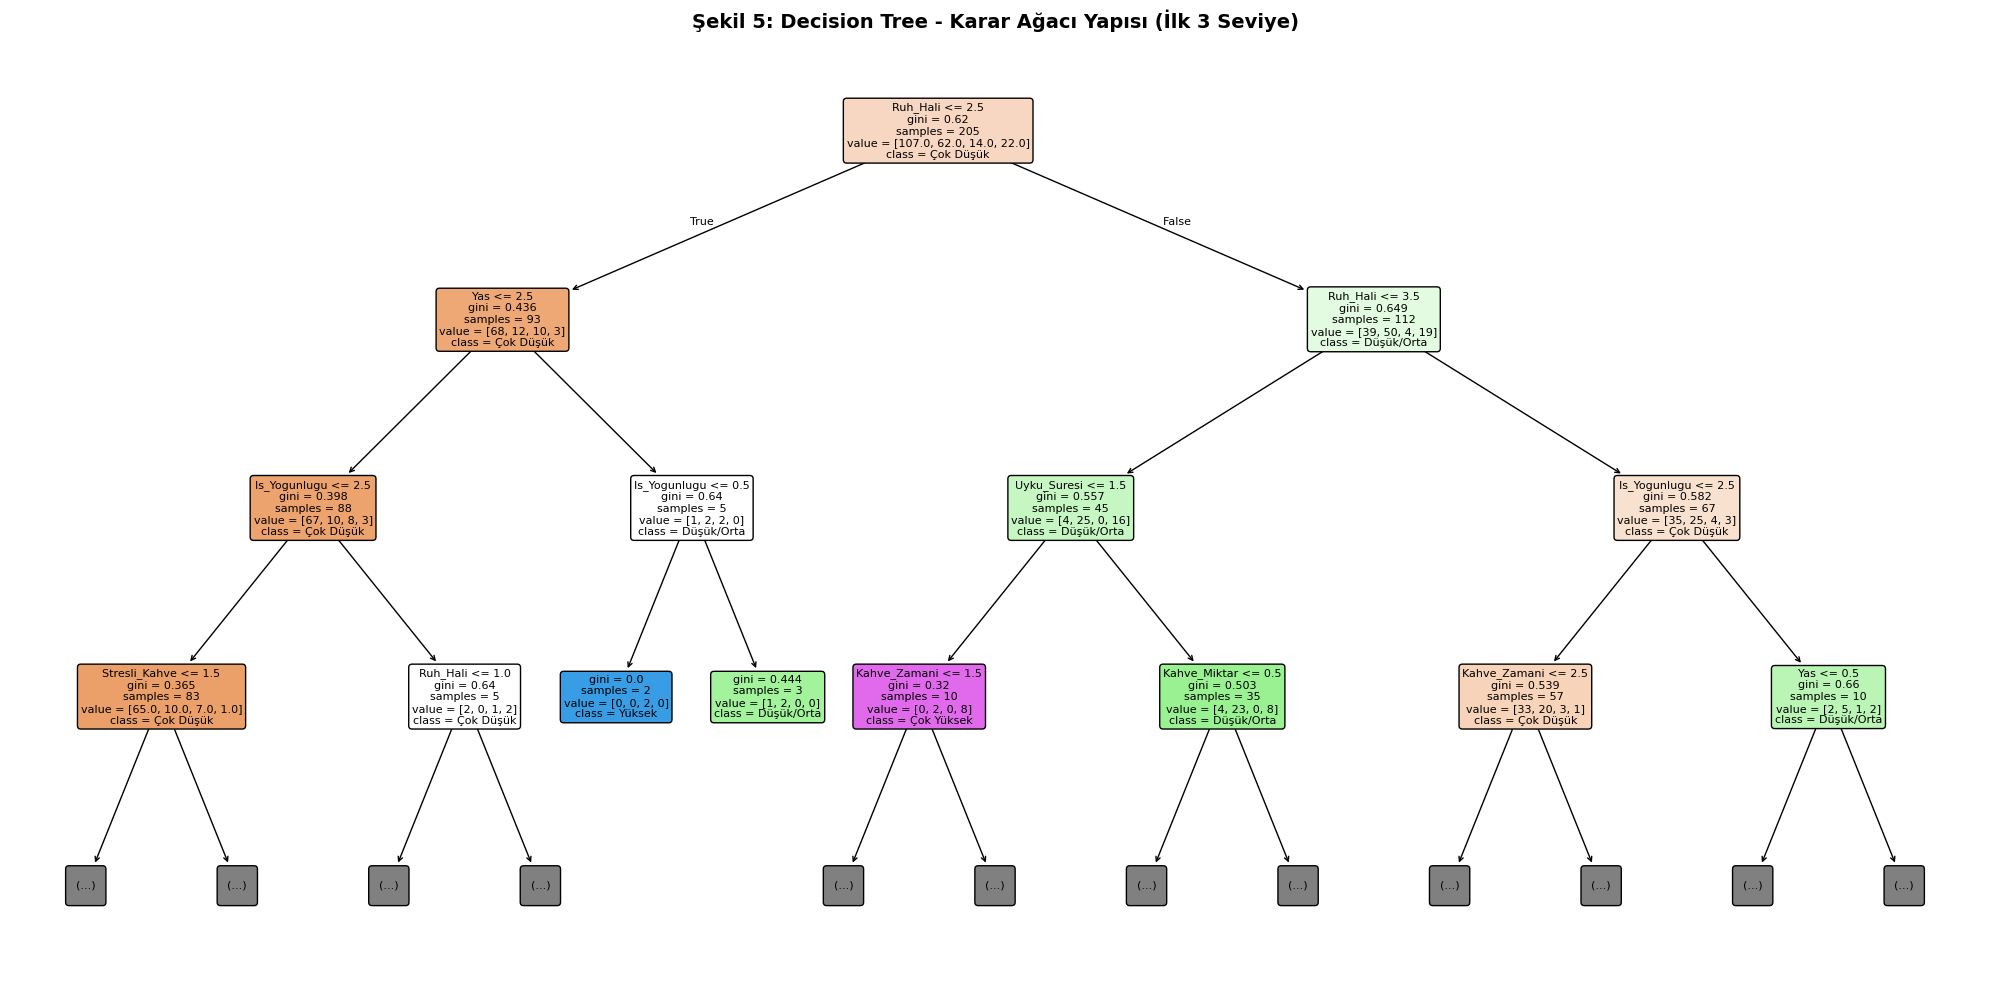

💡 Nasıl Okunur: Her kutu bir karar noktasıdır. Üstteki koşula göre sol/sağ dala gidilir.


In [105]:
# Decision Tree Görselleştirmesi
plt.figure(figsize=(20, 10))
dt_model = models['Decision Tree']
class_names = ['Çok Düşük', 'Düşük/Orta', 'Yüksek', 'Çok Yüksek']

plot_tree(dt_model, 
          feature_names=list(X.columns), 
          class_names=class_names,
          filled=True, 
          rounded=True,
          fontsize=8,
          max_depth=3)

plt.title('Şekil 5: Decision Tree - Karar Ağacı Yapısı (İlk 3 Seviye)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sekil5_decision_tree.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 Nasıl Okunur: Her kutu bir karar noktasıdır. Üstteki koşula göre sol/sağ dala gidilir.")


## 2 Sınıflı Model (Dengesiz Veri Çözümü)

4 sınıflı modelde "Çok Düşük Stres" çok az kişi içerdiği için sınıfları birleştiriyoruz:
- **Düşük Stres** = Çok Düşük Stres + Düşük/Orta Stres
- **Yüksek Stres** = Yüksek Stres + Çok Yüksek Stres


In [106]:
# Sınıf Birleştirme (4 → 2)
def merge_stress(stres):
    if stres in ['Çok Düşük Stres', 'Düşük/Orta Stres']:
        return 'Düşük Stres'
    else:
        return 'Yüksek Stres'

df_ml['Stres_Binary'] = df_ml['Stres_Duzeyi'].apply(merge_stress)

print("📊 YENİ SINIF DAĞILIMI (2 Sınıf):")
print(df_ml['Stres_Binary'].value_counts())

# Encode et
df_bin = df_ml.copy()
for col in df_bin.columns:
    if df_bin[col].dtype == 'object':
        df_bin[col] = LabelEncoder().fit_transform(df_bin[col].astype(str))

X_bin = df_bin.drop(['Stres_Duzeyi', 'Stres_Binary'], axis=1)
y_bin = df_bin['Stres_Binary']
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)

# 2 Sınıflı Modeller
results_bin = []
for name, model in models.items():
    model.fit(X_train_bin, y_train_bin)
    y_pred = model.predict(X_test_bin)
    acc = accuracy_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred, average='weighted')
    results_bin.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1})

results_bin_df = pd.DataFrame(results_bin).sort_values('Accuracy', ascending=False)

print("\n📊 2 SINIFLI MODEL PERFORMANSLARI:")
print("="*50)
print(results_bin_df.to_string(index=False))
print(f"\n🏆 En İyi: {results_bin_df.iloc[0]['Model']} (Acc: {results_bin_df.iloc[0]['Accuracy']*100:.2f}%)")


📊 YENİ SINIF DAĞILIMI (2 Sınıf):
Stres_Binary
Düşük Stres     152
Yüksek Stres    105
Name: count, dtype: int64

📊 2 SINIFLI MODEL PERFORMANSLARI:
        Model  Accuracy  F1-Score
Random Forest  0.730769  0.730769
Decision Tree  0.711538  0.702811
  Naive Bayes  0.615385  0.611779
          KNN  0.596154  0.589941

🏆 En İyi: Random Forest (Acc: 73.08%)


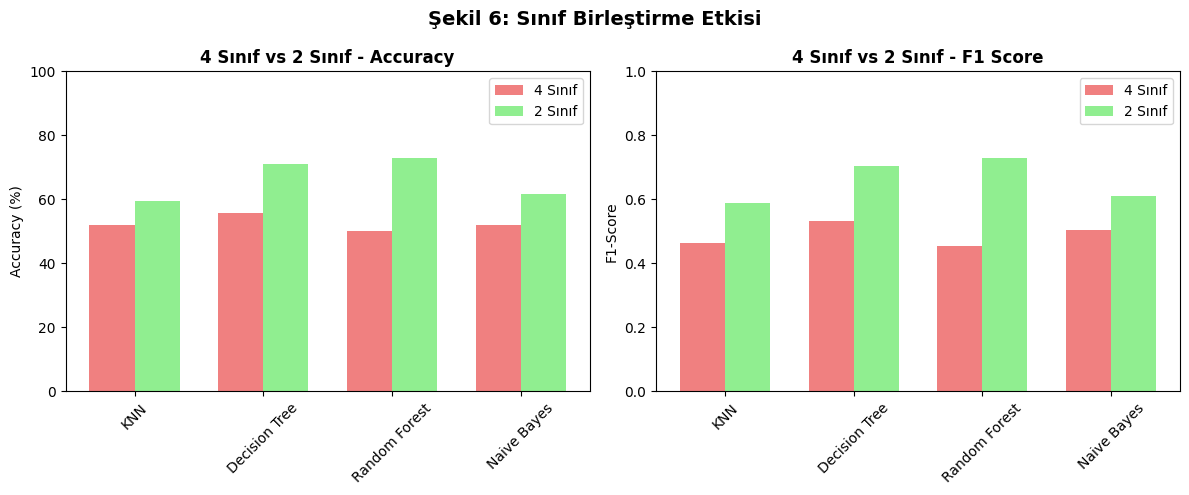


📈 Accuracy İyileşme: %55.77 → %73.08 (+31.0%)


In [107]:
# 4 Sınıf vs 2 Sınıf Karşılaştırma
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

model_names = ['KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']
acc_4 = [r['Accuracy']*100 for r in results]
acc_2 = [r['Accuracy']*100 for r in results_bin]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, acc_4, width, label='4 Sınıf', color='lightcoral')
axes[0].bar(x + width/2, acc_2, width, label='2 Sınıf', color='lightgreen')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('4 Sınıf vs 2 Sınıf - Accuracy', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45)
axes[0].legend()
axes[0].set_ylim([0, 100])

f1_4 = [r['F1-Score'] for r in results]
f1_2 = [r['F1-Score'] for r in results_bin]

axes[1].bar(x - width/2, f1_4, width, label='4 Sınıf', color='lightcoral')
axes[1].bar(x + width/2, f1_2, width, label='2 Sınıf', color='lightgreen')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('4 Sınıf vs 2 Sınıf - F1 Score', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=45)
axes[1].legend()
axes[1].set_ylim([0, 1])

plt.suptitle('Şekil 6: Sınıf Birleştirme Etkisi', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sekil6_2sinif_karsilastirma.png', dpi=150, bbox_inches='tight')
plt.show()

# İyileşme hesapla
best_4 = max(results, key=lambda x: x['Accuracy'])
best_2 = max(results_bin, key=lambda x: x['Accuracy'])
iyilesme = ((best_2['Accuracy'] - best_4['Accuracy']) / best_4['Accuracy']) * 100
print(f"\n📈 Accuracy İyileşme: %{best_4['Accuracy']*100:.2f} → %{best_2['Accuracy']*100:.2f} (+{iyilesme:.1f}%)")
